In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.inspection import partial_dependence

# Suppress warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import shap

# Set font before plotting
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# Data Preprocessing

In [2]:
# Read the CSV
df = pd.read_csv('C:/Users/User/Downloads/Kyushu Datasheets/큐슈제강_조업데이터시트_2024년_전체합본.csv', low_memory=False)

# Drop rows with excessive missing values
missing_count = df.isnull().sum().sum()
if missing_count > 0:
    threshold = df.shape[1] // 2
    df = df.dropna(thresh=threshold + 1)
    print(f"Rows with more than half NaN dropped. Remaining rows: {len(df)}")
else:
    print("No missing values found.")

Rows with more than half NaN dropped. Remaining rows: 2679


In [3]:
# Target variable
target = '사용전력량'

# Clean and filter '강번'
df['강번'] = pd.to_numeric(df['강번'], errors='coerce')
df = df.dropna(subset=['강번'])
df = df[df['강번'].between(9000, 500000000)]

# Outlier removal
if target in df.columns:
    initial_count_oxygen = len(df)
    df = df[df[target] >= 15000]
    removed_count_oxygen = initial_count_oxygen - len(df)
    print(f"Removed {removed_count_oxygen} rows where {target} < 15000.")
else:
    print(f"Warning: '{target}' column not found.")

'''
# Outlier removal
if 'Precipitation (mm)' in df.columns:
    initial_count_oxygen = len(df)
    df = df[df['Precipitation (mm)'] <= 10]
    removed_count_oxygen = initial_count_oxygen - len(df)
    print(f"Removed {removed_count_oxygen} rows where {'Precipitation (mm)'} > 10.")
else:
    print(f"Warning: '{'Precipitation (mm)'}' column not found.")
'''

# For double checking
df.to_csv('For_my_use_1.csv', index=False)

Removed 4 rows where 사용전력량 < 15000.


In [4]:
# Feature engineering
df['slag time'] = df['소요시간_추가1'] + df['소요시간_추가2'] + df['소요시간_산화'] + df['소요시간_환원']
df['slag rate'] = df['CaO'] / 0.24 / df['slag time']

variables = ['slag rate', 'WindSpeed_Avg (m/s)', 'WindSpeed_Max (m/s)', '소요시간_로 보수/수리', '소요시간_주요장입', 
             'Precipitation (mm)', '연회회수', 'Temperature (°C)'
            ]
X = df[variables]
y = df[target]

# Sequential train-test split
split_index = int(len(X) * 0.7)
X_train = X.iloc[:split_index].fillna(0)
X_test = X.iloc[split_index:].fillna(0)
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

In [5]:
# --- Model training and evaluation functions ---

def evaluate_model(name, model, X_train, y_train, X_test, y_test, df):
    print(f"\n--- {name} Model Evaluation ---")
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    # --- Calculate Metrics ---
    # Train
    mse_train = mean_squared_error(y_train, train_pred)
    rmse_train = np.sqrt(mse_train)
    mae_train = mean_absolute_error(y_train, train_pred)
    mape_train = np.mean(np.abs((y_train - train_pred) / y_train)) * 100
    r2_train = r2_score(y_train, train_pred)

    # Test
    mse_test = mean_squared_error(y_test, test_pred)
    rmse_test = np.sqrt(mse_test)
    mae_test = mean_absolute_error(y_test, test_pred)
    mape_test = np.mean(np.abs((y_test - test_pred) / y_test)) * 100
    r2_test = r2_score(y_test, test_pred)

    # --- Print Metrics ---
    print(f"{name} Train Scores:")
    print(f"  MSE:  {mse_train:.2f}")
    print(f"  RMSE: {rmse_train:.2f}")
    print(f"  MAE:  {mae_train:.2f}")
    print(f"  MAPE: {mape_train:.2f}%")
    print(f"  R²:   {r2_train:.3f}")

    print(f"\n{name} Test Scores:")
    print(f"  MSE:  {mse_test:.2f}")
    print(f"  RMSE: {rmse_test:.2f}")
    print(f"  MAE:  {mae_test:.2f}")
    print(f"  MAPE: {mape_test:.2f}%")
    print(f"  R²:   {r2_test:.3f}")
    
    # Plot
    train_df = df[['강번']].loc[X_train.index].copy()
    train_df['Actual'] = y_train.values
    train_df['Predicted'] = train_pred
    train_df['Set'] = 'Train'

    test_df = df[['강번']].loc[X_test.index].copy()
    test_df['Actual'] = y_test.values
    test_df['Predicted'] = test_pred
    test_df['Set'] = 'Test'

    combined_df = pd.concat([train_df, test_df]).sort_values('강번').reset_index(drop=True)
    combined_df['Time Index'] = range(len(combined_df))

    plt.figure(figsize=(16, 4))
    plt.plot(combined_df['Time Index'], combined_df['Actual'], label='Actual', linewidth=2)
    plt.plot(combined_df['Time Index'], combined_df['Predicted'], label='Predicted', linestyle='--', linewidth=2)
    test_start = combined_df[combined_df['Set'] == 'Test']['Time Index'].min()
    plt.axvline(x=test_start, color='red', linestyle=':', label='Test Start')
    plt.xlabel('Time Index (chronological)')
    plt.ylabel(target)
    plt.title(f'Actual vs Predicted {target} ({name}) - R² = {r2_test:.3f}, RMSE = {rmse_test:.1f}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Test-only plot
    test_df = test_df.sort_values('강번').reset_index(drop=True)
    test_df['Time Index'] = range(len(test_df))

    plt.figure(figsize=(18, 3))
    plt.plot(test_df['Time Index'], test_df['Actual'], label='Actual', linewidth=2)
    plt.plot(test_df['Time Index'], test_df['Predicted'], label='Predicted', linestyle='--', linewidth=2)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# MLR


--- Linear Regression Model Evaluation ---
Linear Regression Train Scores:
  MSE:  354246.09
  RMSE: 595.19
  MAE:  464.26
  MAPE: 2.57%
  R²:   0.250

Linear Regression Test Scores:
  MSE:  325317.28
  RMSE: 570.37
  MAE:  443.66
  MAPE: 2.51%
  R²:   0.233


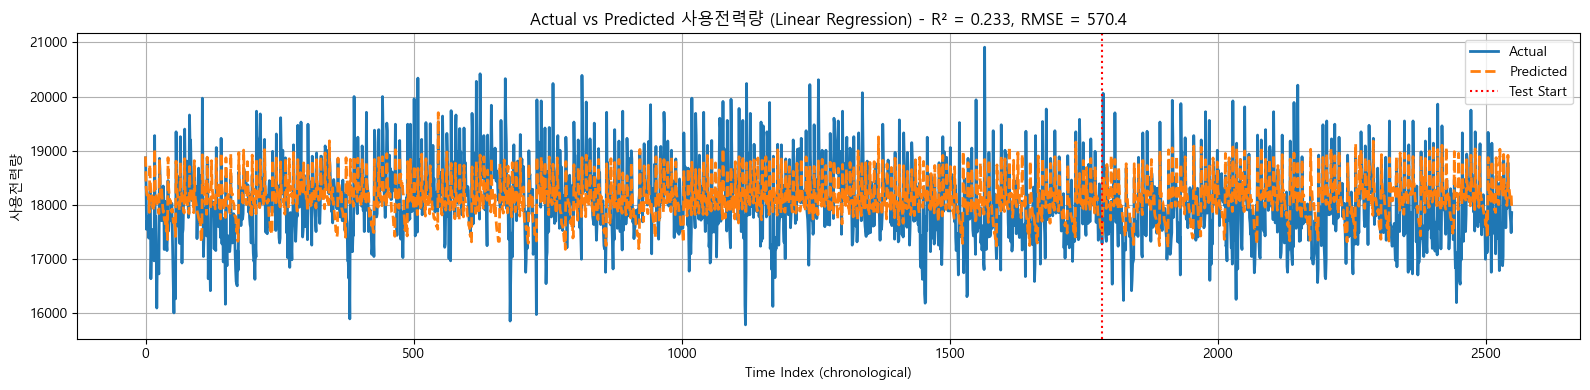

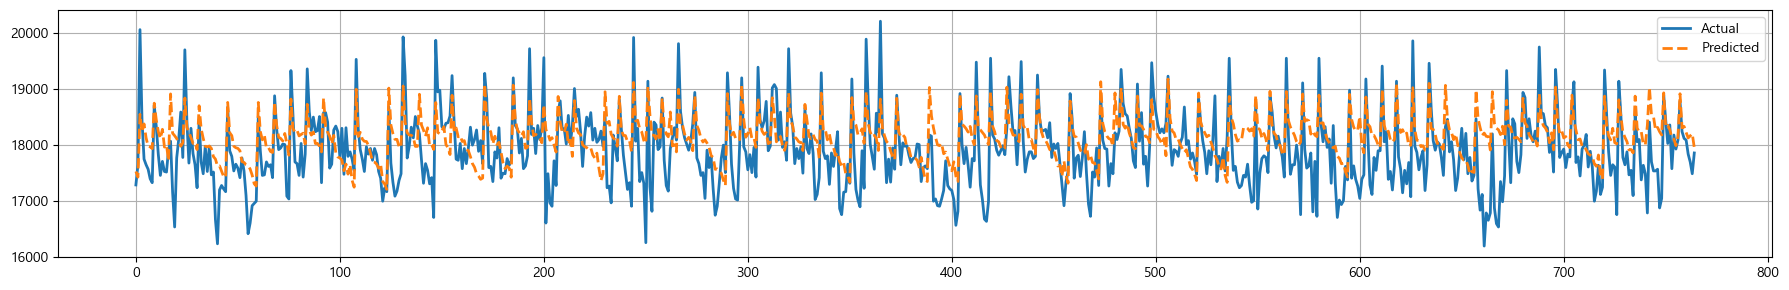

In [6]:
# --- Linear Regression ---
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
evaluate_model("Linear Regression", lin_model, X_train, y_train, X_test, y_test, df)

In [7]:
# Create a DataFrame for better readability
coef_df = pd.DataFrame({
    'Feature': variables,
    'Coefficient': lin_model.coef_
})

print(coef_df)

               Feature  Coefficient
0            slag rate    -4.238839
1  WindSpeed_Avg (m/s)   -23.683844
2  WindSpeed_Max (m/s)    28.692776
3         소요시간_로 보수/수리    -2.312558
4            소요시간_주요장입   117.748657
5   Precipitation (mm)    14.912451
6                 연회회수   -69.445563
7     Temperature (°C)    -2.441405


# XGBoost


--- XGBoost Model Evaluation ---
XGBoost Train Scores:
  MSE:  223661.29
  RMSE: 472.93
  MAE:  362.86
  MAPE: 2.02%
  R²:   0.526

XGBoost Test Scores:
  MSE:  264009.53
  RMSE: 513.82
  MAE:  397.04
  MAPE: 2.25%
  R²:   0.377


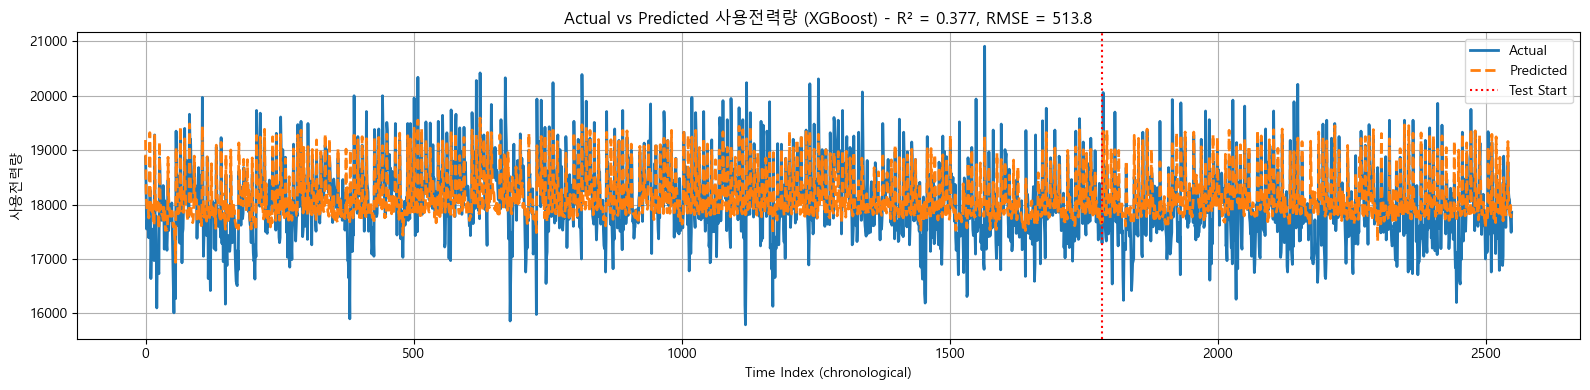

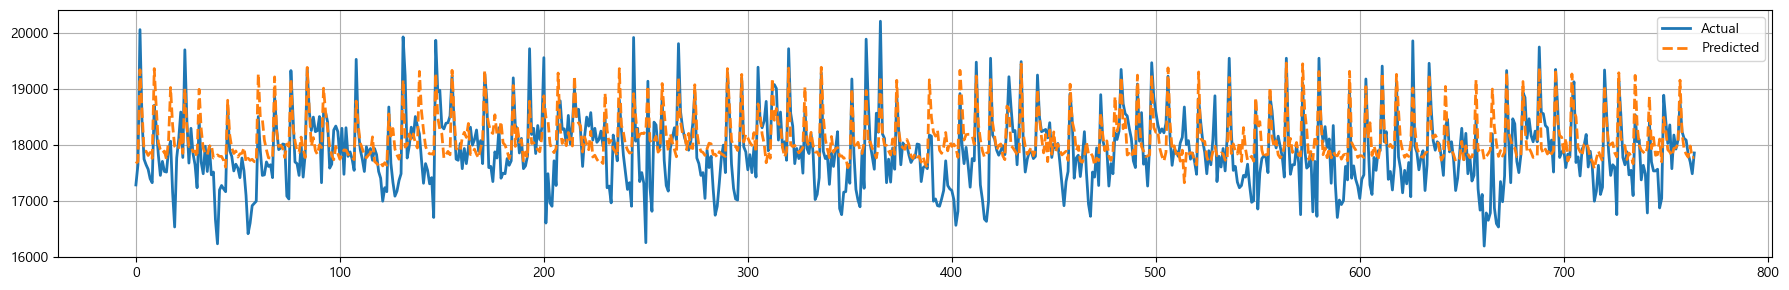

In [8]:
# --- XGBoost ---
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.005,
    max_depth=4,
    random_state=42
)
xgb_model.fit(X_train, y_train)
evaluate_model("XGBoost", xgb_model, X_train, y_train, X_test, y_test, df)

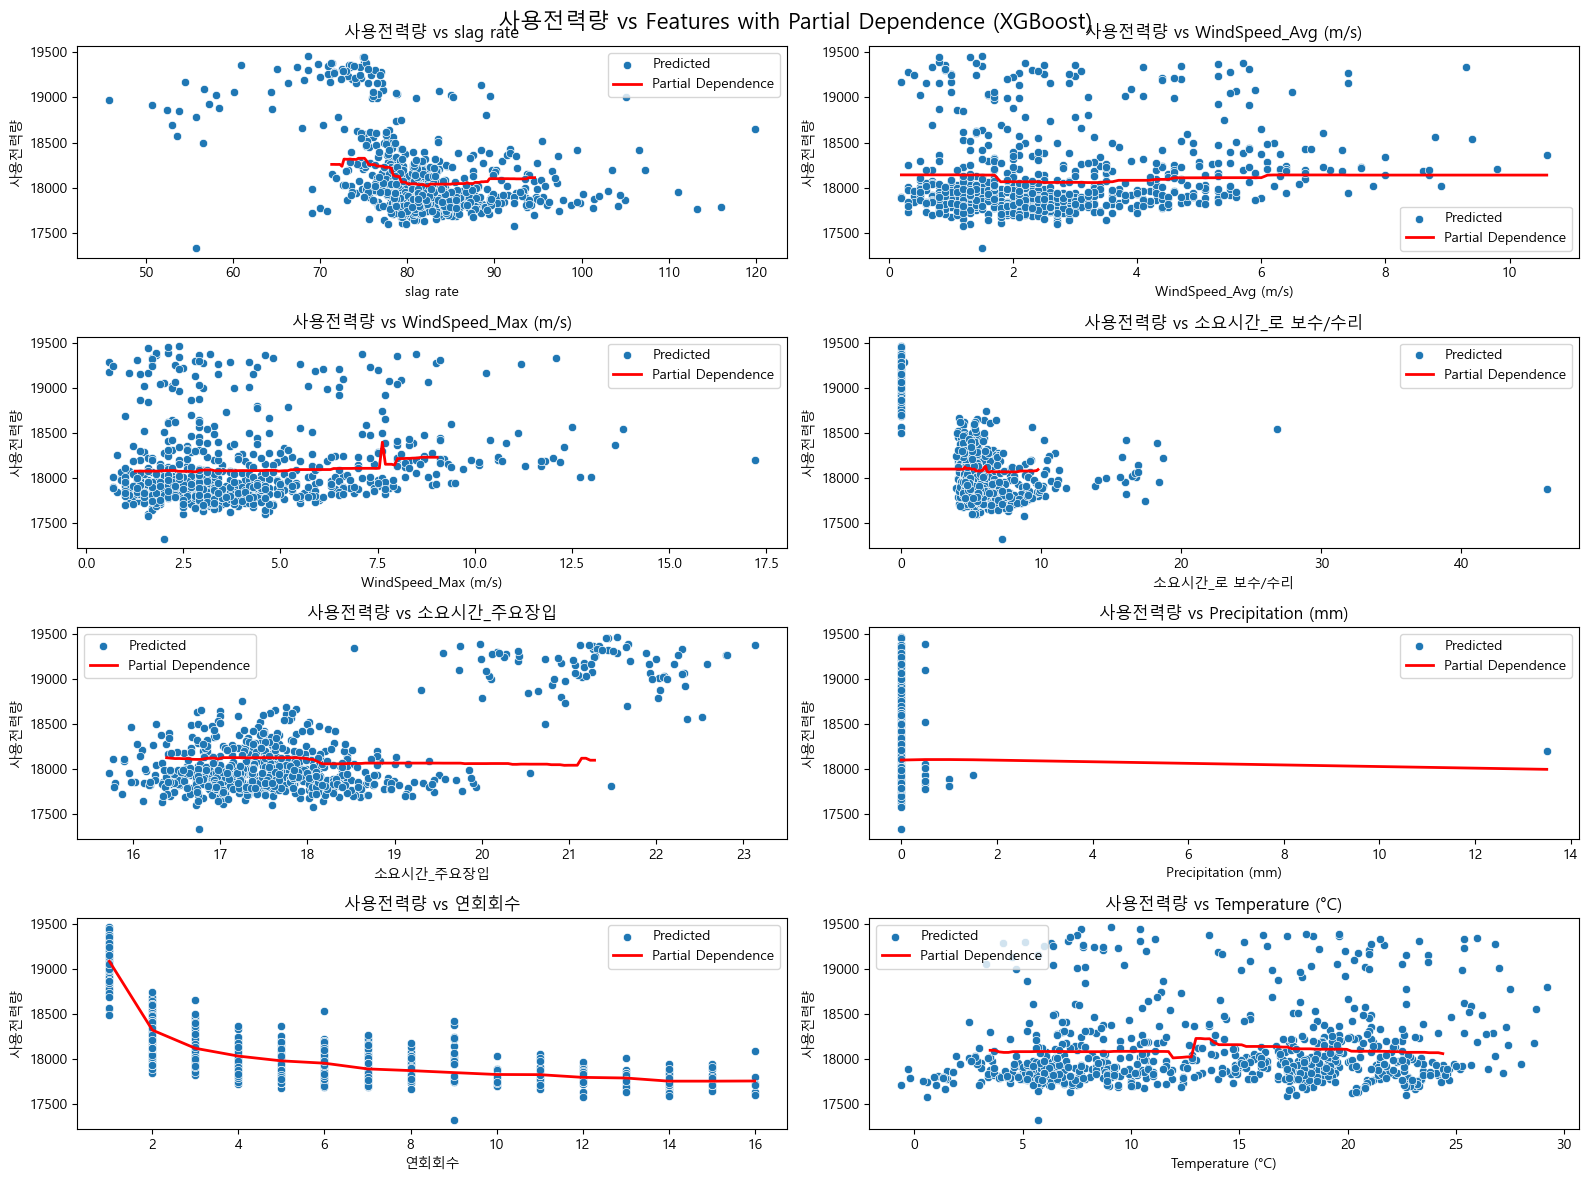

In [9]:
# Features to plot
features = variables
n_features = len(features)

X_test = X_test.astype('float')

# Adjust grid size based on number of features
rows = (n_features + 1) // 2  
fig, axes = plt.subplots(rows, 2, figsize=(16, rows * 3))
axes = axes.flatten()

# Plot the features
for i, feature in enumerate(features):
    ax = axes[i]
    feature_index = X_test.columns.get_loc(feature)

    # Partial dependence
    pd_result = partial_dependence(xgb_model, X_test, [feature_index], kind='average')
    x_vals = pd_result['grid_values'][0]
    y_vals = pd_result['average'][0]

    # Scatter: actual model predictions
    sns.scatterplot(
        x=X_test[feature],
        y=xgb_model.predict(X_test),
        alpha=1,
        ax=ax,
        label='Predicted'
    )

    # Partial dependence line
    ax.plot(x_vals, y_vals, color='red', linewidth=2, label='Partial Dependence')

    # Format
    ax.set_xlabel(feature)
    ax.set_ylabel(f'{target}')
    ax.set_title(f'{target} vs {feature}')
    ax.legend()

# Remove unused axes
for j in range(n_features, len(axes)):
    fig.delaxes(axes[j])

# Improve layout
plt.tight_layout()
plt.subplots_adjust(top=0.95)
fig.suptitle(f'{target} vs Features with Partial Dependence (XGBoost)', fontsize=16)
plt.show()

# Random Forest


--- Random Forest Model Evaluation ---
Random Forest Train Scores:
  MSE:  45954.86
  RMSE: 214.37
  MAE:  162.25
  MAPE: 0.90%
  R²:   0.903

Random Forest Test Scores:
  MSE:  262284.54
  RMSE: 512.14
  MAE:  393.43
  MAPE: 2.22%
  R²:   0.381


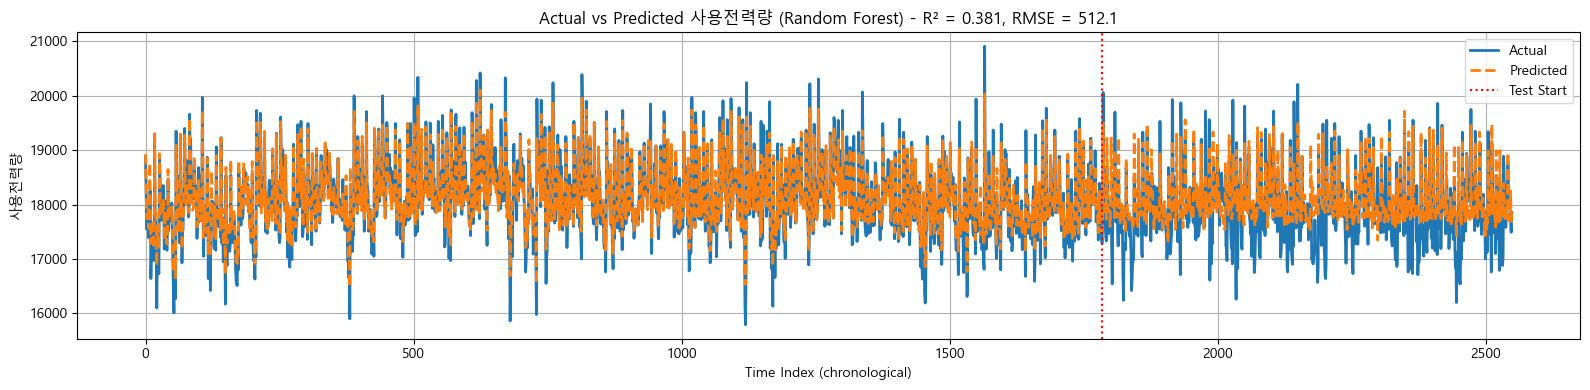

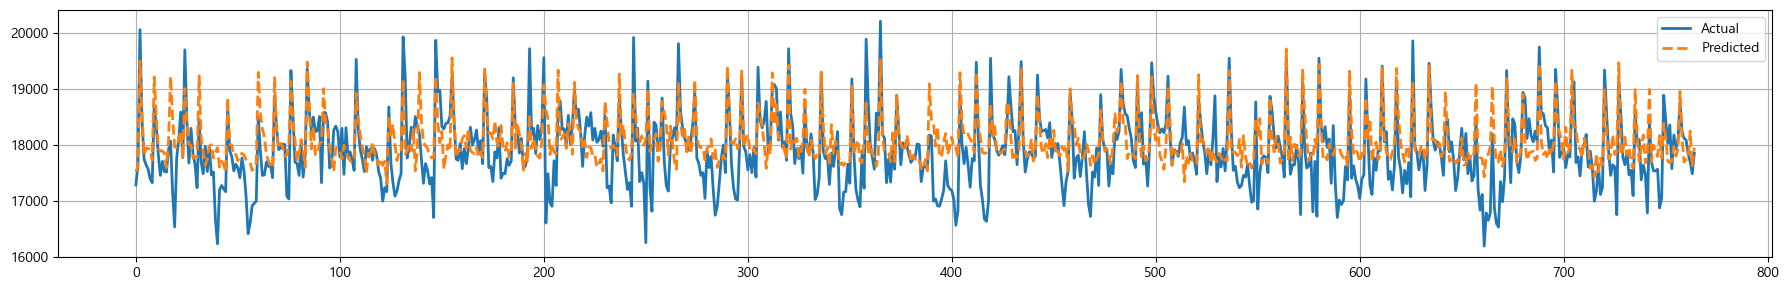

In [10]:
# --- Random Forest ---
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
evaluate_model("Random Forest", rf_model, X_train, y_train, X_test, y_test, df)

# SHAP


--- SHAP Summary: Linear Regression ---


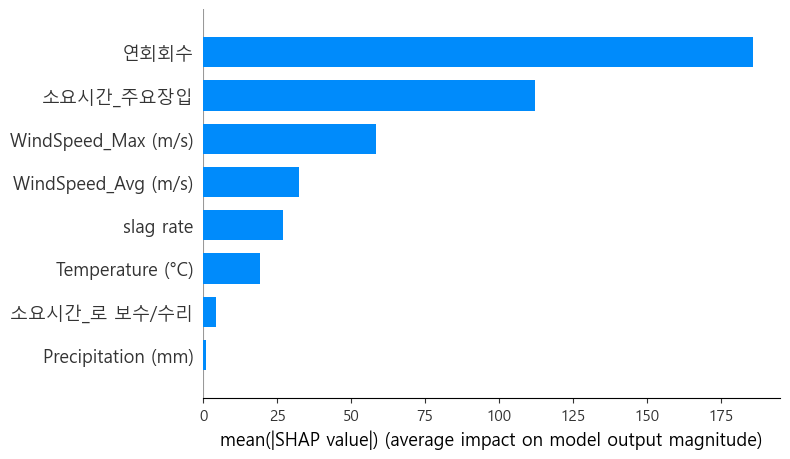

In [11]:
# SHAP for linear model
explainer_lin = shap.Explainer(lin_model, X_train)
shap_values_lin = explainer_lin(X_train)

# Global importance plot
print("\n--- SHAP Summary: Linear Regression ---")
shap.summary_plot(shap_values_lin, X_train, plot_type="bar")

 97%|=================== | 1735/1784 [00:28<00:00]       


--- SHAP Summary: XGBoost ---


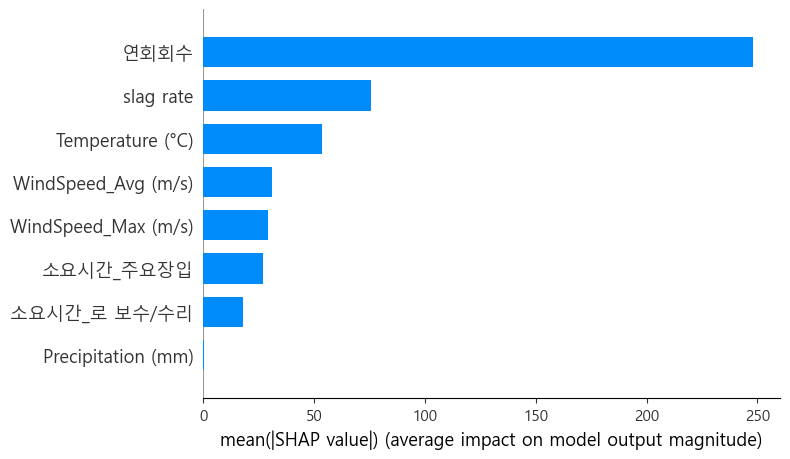

In [12]:
# SHAP for XGBoost (TreeExplainer is fast and accurate)
explainer_xgb = shap.Explainer(xgb_model, X_train)
shap_values_xgb = explainer_xgb(X_train)

# Global importance plot
print("\n--- SHAP Summary: XGBoost ---")
shap.summary_plot(shap_values_xgb, X_train, plot_type="bar")

In [ ]:
# SHAP for Random Forest
explainer_rf = shap.Explainer(rf_model, X_train)
shap_values_rf = explainer_rf(X_train)

# Global importance plot
print("\n--- SHAP Summary: Random Forest ---")
shap.summary_plot(shap_values_rf, X_train, plot_type="bar")

 40%|========            | 719/1784 [00:24<00:35]       